**Deep Learning Project - 1**

In this we are implementing Feed Forward Neural Network from scracth. \\
And using that on Fashion MNIST data set for classification with **GD,SGD,Batch-GD , Momentum, NAG , ADAGrad , RMSProp,ADAM**

In [2]:
import numpy as np
from tqdm import tqdm

In [59]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

#convert the vector of class indices into a matrix containing a one-hot vector for each instance
num_classes = 10
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

     

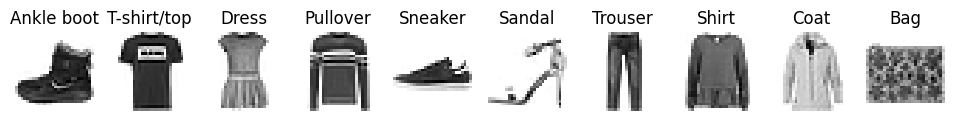

In [60]:
# Sample dataset
class_labels =[]
n_rows = 1
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
index = 0
while (True):
  if y_train[index] not in class_labels:
    plt.subplot(n_rows, n_cols, len(class_labels)+1)
    plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_train[index]], fontsize=12)
    class_labels.append(y_train[index])
  if(len(class_labels)==10):
    break
  index=index+1
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [61]:
#Split the full training set into a validation set and a (smaller) training set. 
#We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

X_train = X_train.reshape(X_train.shape[0], -1) / 255
X_test = X_test.reshape(X_test.shape[0], -1) / 255

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

In [62]:
class PCA:
    def __init__(self, n_components: int) -> None:
        self.n_components = n_components
        self.components = None
    
    def fit(self, X) -> None:
        # fit the PCA model
        cov_matrix = np.cov(X,rowvar=False)
        eignvals, eignvecs = np.linalg.eigh(cov_matrix)
        eignvecs = eignvecs[:, ::-1]
        self.components = eignvecs[:, :self.n_components]
        
    def transform(self, X) -> np.ndarray:
        # transform the data
        transformed_X = np.dot(X, self.components)
        return transformed_X

    def fit_transform(self, X) -> np.ndarray:
        # fit the model and transform the data
        self.fit(X)
        return self.transform(X)

In [63]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [64]:
pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [65]:
class Layer:
  def __init__(self,num_of_inputs,num_of_neurons,activation):
    self.num_of_inputs = num_of_inputs
    self.num_of_neurons = num_of_neurons
    self.activations = activation
    np.random.seed(1234)
    self.W = np.random.randn(num_of_neurons,num_of_inputs)
    self.b = np.random.randn(num_of_neurons)

  def activation(self,input):
    if(self.activations=='ReLu'):
      return np.maximum(0,input)
    elif(self.activations=="sigmoid"):
      return 1/(1+np.exp(-input))
    elif(self.activations=="softmax"):
      max = np.max(input, axis = 1, keepdims=True)
      input -= max
      return(np.exp(input)/np.sum(np.exp(input), axis=1, keepdims=True))
    elif(self.activations=="tanh"):
      return np.tanh(input)
  
  def gradient_activation(self,input):
    if(self.activations=='ReLu'):
      return 1*(input>0)
    elif(self.activations=="sigmoid"):
      return (self.activation(input)*(1-self.activation(input)))
    elif(self.activations=="tanh"):
      return (1 - np.square(self.activation(input)))
  
  def forward(self,prev_H):
    bias = self.b.reshape(-1,1)
    self.A = np.dot(self.W,prev_H.T) + bias
    self.A = self.A.T
    self.H = self.activation(self.A)
    return self.H
  
  def backward(self,grad_A,prev_H,prev_A,gradient_activation):
    self.dW = np.dot(grad_A.T,prev_H)
    self.db = np.sum(grad_A, axis=0)
    grad_prev_H = np.dot(grad_A,self.W)
    derivative = gradient_activation(prev_A)
    grad_prev_A = grad_prev_H * derivative
    return grad_prev_A

In [73]:
from re import I
class Network:
  def __init__(self,num_of_inputs,num_of_hidden_layers,num_of_classes,num_of_neurons,activation):
    self.num_of_inputs = num_of_inputs
    self.num_of_hidden_layers = num_of_hidden_layers
    self.num_of_classes = num_of_classes
    self.num_of_neurons = num_of_neurons
    self.activation = activation
    self.Layers = []
    self.Layers.append(Layer(self.num_of_inputs,self.num_of_neurons,activation))
    for i in range(num_of_hidden_layers-1):
      self.Layers.append(Layer(self.num_of_neurons,self.num_of_neurons,"ReLu"))
    self.Layers.append(Layer(self.num_of_neurons,self.num_of_classes,"softmax"))
  
  def forward(self,inputs):
    self.inputs = inputs
    current_input = inputs
    for i in range(self.num_of_hidden_layers+1):
      current_ouput = self.Layers[i].forward(current_input)
      current_input = current_ouput
    self.y_pred = current_input
    return current_input
  
  def backward(self,outputs):
    grad_A = self.y_pred - outputs
    for i in range(self.num_of_hidden_layers, 0, -1):
      grad_A = self.Layers[i].backward(grad_A,self.Layers[i-1].H,self.Layers[i-1].A,self.Layers[i-1].gradient_activation)
    self.Layers[0].dW = np.dot(grad_A.T,self.inputs)
    self.Layers[0].db = np.sum(grad_A, axis=0)

  def miniBatchGrad(self,dW,db,learning_rate):
    for i in range(self.num_of_hidden_layers+1):
      self.Layers[i].W -= learning_rate*dW[i]
      self.Layers[i].b -= learning_rate*db[i]

  def momentumGrad(self,tW,tb,dW,db,learning_rate,momentum_rate):
    for i in range(self.num_of_hidden_layers+1):
      tW[i] = momentum_rate*tW[i] + learning_rate*dW[i]
      tb[i] = momentum_rate*tb[i] + learning_rate*db[i]
      self.Layers[i].W -= tW[i]
      self.Layers[i].b -= tb[i]
    return tW,tb
  
  def NAGrad(self,tW,tb,dW,db,learning_rate,momentum_rate):
    for i in range(self.num_of_hidden_layers+1):
      tW[i] = momentum_rate*tW[i] + dW[i]
      tb[i] = momentum_rate*tb[i] + db[i]
      self.Layers[i].W -= learning_rate*(momentum_rate*tW[i] + dW[i])
      self.Layers[i].b -= learning_rate*(momentum_rate*tb[i] + db[i])
    return tW,tb

  def AdaGrad(self,vW,vb,dW,db,learning_rate,epsilon=1e-8):
    for i in range(self.num_of_hidden_layers+1):
      vW[i] = vW[i] + dW[i]**2
      vb[i] = vb[i] + db[i]**2
      constantW = learning_rate / np.sqrt(vW[i] + epsilon)
      constantb = learning_rate / np.sqrt(vb[i] + epsilon)
      self.Layers[i].W -= constantW * dW[i]
      self.Layers[i].b -= constantb * db[i]
    return vW,vb

  def RmsProp(self,vW,vb,dW,db,learning_rate,epsilon=1e-8,beta = 0.9):
    for i in range(self.num_of_hidden_layers+1):
      vW[i] = beta*vW[i] + (1-beta)*dW[i]**2
      vb[i] = beta*vb[i] + (1-beta)*db[i]**2
      constantW = learning_rate / np.sqrt(vW[i] + epsilon)
      constantb = learning_rate / np.sqrt(vb[i] + epsilon)
      self.Layers[i].W -= constantW * dW[i]
      self.Layers[i].b -= constantb * db[i]
    return vW,vb
  
  def AdamGrad(self,vW,vb,tW,tb,dW,db,learning_rate,time,epsilon=1e-8,beta1=0.9 , beta2 = 0.999):
    for i in range(self.num_of_hidden_layers+1):
      tW[i] = beta1*tW[i] + (1-beta1)*dW[i]
      tb[i] = beta1*tb[i] + (1-beta1)*db[i]
      vW[i] = beta2*vW[i] + (1-beta2)*dW[i]**2
      vb[i] = beta2*vb[i] + (1-beta2)*db[i]**2
      tW_hat = tW[i]/(1-beta1**time)
      tb_hat = tb[i]/(1-beta1**time)
      vW_hat = vW[i]/(1-beta2**time)
      vb_hat = vb[i]/(1-beta2**time)
      self.Layers[i].W -= learning_rate*tW_hat/(np.sqrt(vW_hat)+epsilon)
      self.Layers[i].b -= learning_rate*tb_hat/(np.sqrt(vb_hat)+epsilon)
    return tW, tb, vW, vb           
    


  def crossEntropy(self, y_pred, y_true):
    return -np.sum(y_true*np.log(y_pred + 1e-9))/y_pred.shape[0]

  def test(self, X_test, y_test):
    self.forward(X_test)
    y_pred = self.Layers[-1].H
    loss = self.crossEntropy(y_pred, y_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    return round((np.sum(y_pred == y_test)/y_test.shape[0])*100,4), round(loss,4)

  
  def train(self,X_train,y_train,X_test,y_test,num_of_epochs,learning_rate,batch_size,opitimizer_fun,momentum_rate=0.9,epislon = 1e-08):
    train_accs= []
    train_losses= []
    test_accs = []
    test_losses = []
    epoch =1 
    while(epoch<=num_of_epochs):
      tW = [np.zeros_like(self.Layers[j].W) for j in range(self.num_of_hidden_layers+1)]
      tb = [np.zeros_like(self.Layers[j].b) for j in range(self.num_of_hidden_layers+1)]
      vW = [np.zeros_like(self.Layers[j].W) for j in range(self.num_of_hidden_layers+1)]
      vb = [np.zeros_like(self.Layers[j].b) for j in range(self.num_of_hidden_layers+1)]
      time = 1
      for i in tqdm(range(0, X_train.shape[0], batch_size)):   
        x = X_train[i:i+batch_size]
        y = y_train[i:i+batch_size]
        self.forward(x)
        self.backward(y)
        dW = [self.Layers[j].dW / X_train.shape[0] for j in range(self.num_of_hidden_layers+1)]
        db = [self.Layers[j].db / X_train.shape[0] for j in range(self.num_of_hidden_layers+1)]
        if(opitimizer_fun == "miniBatchGrad"):
          self.miniBatchGrad(dW, db, learning_rate)
        elif(opitimizer_fun == "momentumGrad"):
          tW,tb = self.momentumGrad(tW, tb,dW, db, learning_rate, momentum_rate)
        elif(opitimizer_fun == "NAGrad"):
          tW,tb = self.NAGrad(tW, tb,dW, db,learning_rate, momentum_rate)
        elif(opitimizer_fun =="AdaGrad"):
          vW,vb = self.AdaGrad(vW,vb,dW,db,learning_rate)
        elif(opitimizer_fun =="RmsProp"):
          vW,vb = self.RmsProp(vW,vb,dW,db,learning_rate)
        elif(opitimizer_fun =="AdamGrad"):
          tW,tb,vW,vb = self.AdamGrad(vW,vb,tW,tb,dW,db,learning_rate,time)
        time=time+1
      train_acc, train_loss = self.test(X_train, y_train)
      test_acc, test_loss = self.test(X_test, y_test)
      train_accs.append(train_acc)
      train_losses.append(train_loss)
      test_accs.append(test_acc)
      test_losses.append(test_loss)
      print(f"Epoch : {epoch}  train_acc : {train_acc} train_loss : {train_loss} test_acc : {test_acc} test_loss : {test_loss}")
      epoch = epoch+1
      if(epoch%3==0):
        learning_rate = learning_rate/2
    return train_accs,train_losses,test_accs,test_losses

In [77]:
num_of_inputs=100
num_of_hidden_layers= 4
num_of_classes = 10
num_of_neurons = 128
activation = "sigmoid"
nn = Network(num_of_inputs,num_of_hidden_layers,num_of_classes,num_of_neurons,activation)
num_of_epochs= 20
learning_rate = 1e-2
batch_size = 32
opitimizer_fun = "miniBatchGrad"
train_accs1,train_losses1,test_accs1,test_losses1=nn.train(X_train,y_train,X_test,y_test,num_of_epochs,learning_rate,batch_size,opitimizer_fun)

  8%|▊         | 157/1875 [00:00<00:06, 256.27it/s]<ipython-input-65-23e4a3d8067c>:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
100%|██████████| 1875/1875 [00:05<00:00, 321.21it/s]


Epoch : 1  train_acc : 51.885 train_loss : 9.9302 test_acc : 51.56 test_loss : 10.0008


100%|██████████| 1875/1875 [00:04<00:00, 407.71it/s]


Epoch : 2  train_acc : 59.955 train_loss : 8.2483 test_acc : 59.3 test_loss : 8.3854


100%|██████████| 1875/1875 [00:06<00:00, 304.22it/s]


Epoch : 3  train_acc : 61.9667 train_loss : 7.8289 test_acc : 61.19 test_loss : 7.9976


100%|██████████| 1875/1875 [00:04<00:00, 400.98it/s]


Epoch : 4  train_acc : 63.4333 train_loss : 7.5274 test_acc : 62.33 test_loss : 7.7569


100%|██████████| 1875/1875 [00:07<00:00, 250.15it/s]


Epoch : 5  train_acc : 64.4417 train_loss : 7.3095 test_acc : 63.58 test_loss : 7.4758


100%|██████████| 1875/1875 [00:09<00:00, 203.95it/s]


Epoch : 6  train_acc : 64.81 train_loss : 7.2273 test_acc : 64.14 test_loss : 7.3796


100%|██████████| 1875/1875 [00:06<00:00, 295.02it/s]


Epoch : 7  train_acc : 65.2483 train_loss : 7.1434 test_acc : 64.48 test_loss : 7.2906


100%|██████████| 1875/1875 [00:06<00:00, 299.78it/s]


Epoch : 8  train_acc : 65.58 train_loss : 7.073 test_acc : 64.84 test_loss : 7.2302


100%|██████████| 1875/1875 [00:04<00:00, 400.09it/s]


Epoch : 9  train_acc : 65.72 train_loss : 7.0384 test_acc : 64.95 test_loss : 7.2049


100%|██████████| 1875/1875 [00:06<00:00, 284.12it/s]


Epoch : 10  train_acc : 65.9467 train_loss : 6.9944 test_acc : 65.16 test_loss : 7.1737


100%|██████████| 1875/1875 [00:10<00:00, 173.15it/s]


Epoch : 11  train_acc : 66.145 train_loss : 6.9551 test_acc : 65.24 test_loss : 7.148


100%|██████████| 1875/1875 [00:05<00:00, 333.77it/s]


Epoch : 12  train_acc : 66.2233 train_loss : 6.9422 test_acc : 65.3 test_loss : 7.1443


100%|██████████| 1875/1875 [00:11<00:00, 162.21it/s]


Epoch : 13  train_acc : 66.29 train_loss : 6.9269 test_acc : 65.38 test_loss : 7.133


100%|██████████| 1875/1875 [00:06<00:00, 275.32it/s]


Epoch : 14  train_acc : 66.355 train_loss : 6.9091 test_acc : 65.38 test_loss : 7.1208


100%|██████████| 1875/1875 [00:04<00:00, 398.09it/s]


Epoch : 15  train_acc : 66.3983 train_loss : 6.9004 test_acc : 65.42 test_loss : 7.1142


100%|██████████| 1875/1875 [00:06<00:00, 299.63it/s]


Epoch : 16  train_acc : 66.4383 train_loss : 6.8912 test_acc : 65.45 test_loss : 7.1061


100%|██████████| 1875/1875 [00:04<00:00, 391.13it/s]


Epoch : 17  train_acc : 66.4717 train_loss : 6.8813 test_acc : 65.47 test_loss : 7.0971


100%|██████████| 1875/1875 [00:06<00:00, 290.43it/s]


Epoch : 18  train_acc : 66.48 train_loss : 6.8772 test_acc : 65.48 test_loss : 7.0941


100%|██████████| 1875/1875 [00:04<00:00, 394.74it/s]


Epoch : 19  train_acc : 66.5 train_loss : 6.8722 test_acc : 65.46 test_loss : 7.0902


100%|██████████| 1875/1875 [00:06<00:00, 309.88it/s]


Epoch : 20  train_acc : 66.5267 train_loss : 6.8672 test_acc : 65.48 test_loss : 7.0866


In [76]:
num_of_inputs=100
num_of_hidden_layers= 4
num_of_classes = 10
num_of_neurons = 128
activation = "sigmoid"
nn = Network(num_of_inputs,num_of_hidden_layers,num_of_classes,num_of_neurons,activation)
num_of_epochs= 20
learning_rate = 1e-2
batch_size = 32
opitimizer_fun = "momentumGrad"
train_accs2,train_losses2,test_accs2,test_losses2=nn.train(X_train,y_train,X_test,y_test,num_of_epochs,learning_rate,batch_size,opitimizer_fun)

  8%|▊         | 150/1875 [00:00<00:10, 158.94it/s]<ipython-input-65-23e4a3d8067c>:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
100%|██████████| 1875/1875 [00:07<00:00, 243.79it/s]


Epoch : 1  train_acc : 69.6683 train_loss : 6.218 test_acc : 68.79 test_loss : 6.407


100%|██████████| 1875/1875 [00:06<00:00, 298.19it/s]


Epoch : 2  train_acc : 72.0683 train_loss : 5.7008 test_acc : 70.6 test_loss : 6.0016


100%|██████████| 1875/1875 [00:05<00:00, 351.21it/s]


Epoch : 3  train_acc : 72.7367 train_loss : 5.538 test_acc : 70.93 test_loss : 5.9231


100%|██████████| 1875/1875 [00:06<00:00, 277.62it/s]


Epoch : 4  train_acc : 73.4417 train_loss : 5.3876 test_acc : 71.44 test_loss : 5.8061


100%|██████████| 1875/1875 [00:05<00:00, 348.17it/s]


Epoch : 5  train_acc : 74.0417 train_loss : 5.2378 test_acc : 72.09 test_loss : 5.6835


100%|██████████| 1875/1875 [00:06<00:00, 278.45it/s]


Epoch : 6  train_acc : 74.3017 train_loss : 5.1846 test_acc : 72.39 test_loss : 5.6175


100%|██████████| 1875/1875 [00:05<00:00, 353.71it/s]


Epoch : 7  train_acc : 74.4367 train_loss : 5.1496 test_acc : 72.48 test_loss : 5.604


100%|██████████| 1875/1875 [00:06<00:00, 279.90it/s]


Epoch : 8  train_acc : 74.645 train_loss : 5.1054 test_acc : 72.5 test_loss : 5.5632


100%|██████████| 1875/1875 [00:05<00:00, 353.73it/s]


Epoch : 9  train_acc : 74.6033 train_loss : 5.1126 test_acc : 72.4 test_loss : 5.5952


100%|██████████| 1875/1875 [00:06<00:00, 277.23it/s]


Epoch : 10  train_acc : 74.6933 train_loss : 5.0918 test_acc : 72.34 test_loss : 5.5909


100%|██████████| 1875/1875 [00:05<00:00, 355.66it/s]


Epoch : 11  train_acc : 74.6967 train_loss : 5.079 test_acc : 72.32 test_loss : 5.59


100%|██████████| 1875/1875 [00:06<00:00, 295.57it/s]


Epoch : 12  train_acc : 74.7133 train_loss : 5.0771 test_acc : 72.17 test_loss : 5.6048


100%|██████████| 1875/1875 [00:09<00:00, 206.73it/s]


Epoch : 13  train_acc : 74.7317 train_loss : 5.0696 test_acc : 72.18 test_loss : 5.6047


100%|██████████| 1875/1875 [00:08<00:00, 224.75it/s]


Epoch : 14  train_acc : 74.7683 train_loss : 5.0599 test_acc : 72.2 test_loss : 5.6067


100%|██████████| 1875/1875 [00:07<00:00, 260.69it/s]


Epoch : 15  train_acc : 74.78 train_loss : 5.0537 test_acc : 72.21 test_loss : 5.6148


100%|██████████| 1875/1875 [00:06<00:00, 274.73it/s]


Epoch : 16  train_acc : 74.785 train_loss : 5.0492 test_acc : 72.24 test_loss : 5.6127


100%|██████████| 1875/1875 [00:05<00:00, 349.06it/s]


Epoch : 17  train_acc : 74.7817 train_loss : 5.0451 test_acc : 72.26 test_loss : 5.608


100%|██████████| 1875/1875 [00:11<00:00, 165.32it/s]


Epoch : 18  train_acc : 74.7733 train_loss : 5.0408 test_acc : 72.23 test_loss : 5.6037


100%|██████████| 1875/1875 [00:10<00:00, 177.07it/s]


Epoch : 19  train_acc : 74.775 train_loss : 5.0381 test_acc : 72.22 test_loss : 5.6006


100%|██████████| 1875/1875 [00:11<00:00, 160.32it/s]


Epoch : 20  train_acc : 74.775 train_loss : 5.0357 test_acc : 72.26 test_loss : 5.5977


In [70]:
num_of_inputs=100
num_of_hidden_layers= 4
num_of_classes = 10
num_of_neurons = 128
activation = "sigmoid"
nn = Network(num_of_inputs,num_of_hidden_layers,num_of_classes,num_of_neurons,activation)
num_of_epochs= 20
learning_rate = 1e-2
batch_size = 32
opitimizer_fun = "AdaGrad"
train_accs3,train_losses3,test_accs3,test_losses3=nn.train(X_train,y_train,X_test,y_test,num_of_epochs,learning_rate,batch_size,opitimizer_fun)

  7%|▋         | 123/1875 [00:00<00:04, 371.96it/s]<ipython-input-65-23e4a3d8067c>:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
100%|██████████| 1875/1875 [00:07<00:00, 264.07it/s]


Epoch : 1  train_acc : 71.0183 train_loss : 5.9465 test_acc : 69.44 test_loss : 6.2648


100%|██████████| 1875/1875 [00:05<00:00, 333.08it/s]


Epoch : 2  train_acc : 75.01 train_loss : 5.0899 test_acc : 73.05 test_loss : 5.5218


100%|██████████| 1875/1875 [00:07<00:00, 250.76it/s]


Epoch : 3  train_acc : 76.4733 train_loss : 4.7662 test_acc : 73.95 test_loss : 5.3198


100%|██████████| 1875/1875 [00:06<00:00, 312.14it/s]


Epoch : 4  train_acc : 77.49 train_loss : 4.5597 test_acc : 74.45 test_loss : 5.1982


100%|██████████| 1875/1875 [00:06<00:00, 282.08it/s]


Epoch : 5  train_acc : 78.4283 train_loss : 4.3447 test_acc : 74.62 test_loss : 5.1314


100%|██████████| 1875/1875 [00:07<00:00, 250.26it/s]


Epoch : 6  train_acc : 78.9233 train_loss : 4.2325 test_acc : 74.83 test_loss : 5.1056


100%|██████████| 1875/1875 [00:06<00:00, 306.65it/s]


Epoch : 7  train_acc : 79.27 train_loss : 4.1594 test_acc : 74.98 test_loss : 5.0932


100%|██████████| 1875/1875 [00:07<00:00, 243.37it/s]


Epoch : 8  train_acc : 79.7033 train_loss : 4.0689 test_acc : 74.93 test_loss : 5.0852


100%|██████████| 1875/1875 [00:06<00:00, 311.51it/s]


Epoch : 9  train_acc : 79.88 train_loss : 4.0152 test_acc : 74.92 test_loss : 5.0736


100%|██████████| 1875/1875 [00:06<00:00, 284.43it/s]


Epoch : 10  train_acc : 79.98 train_loss : 3.9884 test_acc : 74.97 test_loss : 5.0695


100%|██████████| 1875/1875 [00:07<00:00, 251.53it/s]


Epoch : 11  train_acc : 80.1583 train_loss : 3.9568 test_acc : 75.05 test_loss : 5.0651


100%|██████████| 1875/1875 [00:06<00:00, 303.68it/s]


Epoch : 12  train_acc : 80.3233 train_loss : 3.9138 test_acc : 75.04 test_loss : 5.0471


100%|██████████| 1875/1875 [00:07<00:00, 238.27it/s]


Epoch : 13  train_acc : 80.39 train_loss : 3.8975 test_acc : 75.07 test_loss : 5.0428


100%|██████████| 1875/1875 [00:06<00:00, 280.39it/s]


Epoch : 14  train_acc : 80.435 train_loss : 3.8769 test_acc : 75.17 test_loss : 5.0276


100%|██████████| 1875/1875 [00:06<00:00, 306.31it/s]


Epoch : 15  train_acc : 80.5 train_loss : 3.8536 test_acc : 75.1 test_loss : 5.0296


100%|██████████| 1875/1875 [00:07<00:00, 243.72it/s]


Epoch : 16  train_acc : 80.5483 train_loss : 3.8473 test_acc : 75.06 test_loss : 5.0348


100%|██████████| 1875/1875 [00:08<00:00, 221.71it/s]


Epoch : 17  train_acc : 80.6033 train_loss : 3.8347 test_acc : 75.06 test_loss : 5.0439


100%|██████████| 1875/1875 [00:09<00:00, 207.30it/s]


Epoch : 18  train_acc : 80.5783 train_loss : 3.8325 test_acc : 75.05 test_loss : 5.0423


100%|██████████| 1875/1875 [00:07<00:00, 262.74it/s]


Epoch : 19  train_acc : 80.6233 train_loss : 3.8262 test_acc : 75.09 test_loss : 5.0407


100%|██████████| 1875/1875 [00:07<00:00, 253.66it/s]


Epoch : 20  train_acc : 80.6417 train_loss : 3.8205 test_acc : 75.07 test_loss : 5.0401


In [71]:
num_of_inputs=100
num_of_hidden_layers= 4
num_of_classes = 10
num_of_neurons = 128
activation = "sigmoid"
nn = Network(num_of_inputs,num_of_hidden_layers,num_of_classes,num_of_neurons,activation)
num_of_epochs= 20
learning_rate = 1e-2
batch_size = 32
opitimizer_fun = "RmsProp"
train_accs4,train_losses4,test_accs4,test_losses4=nn.train(X_train,y_train,X_test,y_test,num_of_epochs,learning_rate,batch_size,opitimizer_fun)

  6%|▋         | 120/1875 [00:00<00:04, 387.55it/s]<ipython-input-65-23e4a3d8067c>:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
100%|██████████| 1875/1875 [00:06<00:00, 301.97it/s]


Epoch : 1  train_acc : 71.1983 train_loss : 1.3398 test_acc : 70.39 test_loss : 1.4439


100%|██████████| 1875/1875 [00:04<00:00, 447.54it/s]


Epoch : 2  train_acc : 79.2933 train_loss : 0.6042 test_acc : 77.56 test_loss : 0.6998


100%|██████████| 1875/1875 [00:05<00:00, 366.46it/s]


Epoch : 3  train_acc : 81.0267 train_loss : 0.5307 test_acc : 79.01 test_loss : 0.6365


100%|██████████| 1875/1875 [00:04<00:00, 452.93it/s]


Epoch : 4  train_acc : 81.5817 train_loss : 0.5164 test_acc : 79.37 test_loss : 0.6269


100%|██████████| 1875/1875 [00:04<00:00, 453.59it/s]


Epoch : 5  train_acc : 81.8867 train_loss : 0.5014 test_acc : 79.37 test_loss : 0.6189


100%|██████████| 1875/1875 [00:05<00:00, 329.73it/s]


Epoch : 6  train_acc : 82.475 train_loss : 0.483 test_acc : 79.96 test_loss : 0.6041


100%|██████████| 1875/1875 [00:04<00:00, 444.22it/s]


Epoch : 7  train_acc : 82.6067 train_loss : 0.4781 test_acc : 79.96 test_loss : 0.6007


100%|██████████| 1875/1875 [00:05<00:00, 324.02it/s]


Epoch : 8  train_acc : 82.8133 train_loss : 0.4721 test_acc : 80.02 test_loss : 0.5961


100%|██████████| 1875/1875 [00:04<00:00, 442.20it/s]


Epoch : 9  train_acc : 83.0367 train_loss : 0.462 test_acc : 80.16 test_loss : 0.5851


100%|██████████| 1875/1875 [00:06<00:00, 293.61it/s]


Epoch : 10  train_acc : 83.1633 train_loss : 0.4592 test_acc : 80.23 test_loss : 0.5833


100%|██████████| 1875/1875 [00:04<00:00, 439.35it/s]


Epoch : 11  train_acc : 83.2417 train_loss : 0.4567 test_acc : 80.26 test_loss : 0.582


100%|██████████| 1875/1875 [00:04<00:00, 384.77it/s]


Epoch : 12  train_acc : 83.3967 train_loss : 0.452 test_acc : 80.48 test_loss : 0.5757


100%|██████████| 1875/1875 [00:04<00:00, 435.21it/s]


Epoch : 13  train_acc : 83.4517 train_loss : 0.4507 test_acc : 80.52 test_loss : 0.5746


100%|██████████| 1875/1875 [00:04<00:00, 443.83it/s]


Epoch : 14  train_acc : 83.48 train_loss : 0.4497 test_acc : 80.57 test_loss : 0.5739


100%|██████████| 1875/1875 [00:05<00:00, 328.47it/s]


Epoch : 15  train_acc : 83.5467 train_loss : 0.4476 test_acc : 80.67 test_loss : 0.571


100%|██████████| 1875/1875 [00:04<00:00, 444.54it/s]


Epoch : 16  train_acc : 83.575 train_loss : 0.447 test_acc : 80.71 test_loss : 0.5706


100%|██████████| 1875/1875 [00:05<00:00, 318.04it/s]


Epoch : 17  train_acc : 83.6033 train_loss : 0.4464 test_acc : 80.73 test_loss : 0.5702


100%|██████████| 1875/1875 [00:04<00:00, 440.46it/s]


Epoch : 18  train_acc : 83.6533 train_loss : 0.445 test_acc : 80.81 test_loss : 0.5686


100%|██████████| 1875/1875 [00:05<00:00, 322.39it/s]


Epoch : 19  train_acc : 83.67 train_loss : 0.4447 test_acc : 80.83 test_loss : 0.5683


100%|██████████| 1875/1875 [00:04<00:00, 444.43it/s]


Epoch : 20  train_acc : 83.675 train_loss : 0.4444 test_acc : 80.86 test_loss : 0.5682


In [75]:
num_of_inputs=100
num_of_hidden_layers= 4
num_of_classes = 10
num_of_neurons = 128
activation = "sigmoid"
nn = Network(num_of_inputs,num_of_hidden_layers,num_of_classes,num_of_neurons,activation)
num_of_epochs=  20
learning_rate = 1e-2
batch_size = 32
opitimizer_fun = "AdamGrad"
train_accs5,train_losses5,test_accs5,test_losses5=nn.train(X_train,y_train,X_test,y_test,num_of_epochs,learning_rate,batch_size,opitimizer_fun)

  8%|▊         | 153/1875 [00:00<00:10, 162.21it/s]<ipython-input-65-23e4a3d8067c>:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
100%|██████████| 1875/1875 [00:06<00:00, 295.93it/s]


Epoch : 1  train_acc : 69.7383 train_loss : 4.0391 test_acc : 69.17 test_loss : 4.2314


100%|██████████| 1875/1875 [00:06<00:00, 302.97it/s]


Epoch : 2  train_acc : 75.2583 train_loss : 0.8501 test_acc : 73.6 test_loss : 0.9636


100%|██████████| 1875/1875 [00:04<00:00, 381.30it/s]


Epoch : 3  train_acc : 81.2733 train_loss : 0.5433 test_acc : 79.47 test_loss : 0.6273


100%|██████████| 1875/1875 [00:05<00:00, 317.69it/s]


Epoch : 4  train_acc : 83.6167 train_loss : 0.4897 test_acc : 81.61 test_loss : 0.5815


100%|██████████| 1875/1875 [00:04<00:00, 383.85it/s]


Epoch : 5  train_acc : 85.4433 train_loss : 0.4145 test_acc : 83.05 test_loss : 0.5146


100%|██████████| 1875/1875 [00:05<00:00, 320.62it/s]


Epoch : 6  train_acc : 86.885 train_loss : 0.366 test_acc : 83.79 test_loss : 0.4838


100%|██████████| 1875/1875 [00:04<00:00, 383.39it/s]


Epoch : 7  train_acc : 87.365 train_loss : 0.3582 test_acc : 83.96 test_loss : 0.4861


100%|██████████| 1875/1875 [00:05<00:00, 319.11it/s]


Epoch : 8  train_acc : 88.2117 train_loss : 0.3332 test_acc : 84.54 test_loss : 0.4787


100%|██████████| 1875/1875 [00:04<00:00, 385.25it/s]


Epoch : 9  train_acc : 88.6633 train_loss : 0.3131 test_acc : 84.41 test_loss : 0.4795


100%|██████████| 1875/1875 [00:05<00:00, 324.93it/s]


Epoch : 10  train_acc : 89.13 train_loss : 0.2982 test_acc : 84.57 test_loss : 0.4747


100%|██████████| 1875/1875 [00:04<00:00, 383.98it/s]


Epoch : 11  train_acc : 89.3567 train_loss : 0.2905 test_acc : 84.9 test_loss : 0.4953


100%|██████████| 1875/1875 [00:05<00:00, 319.91it/s]


Epoch : 12  train_acc : 89.845 train_loss : 0.2774 test_acc : 84.91 test_loss : 0.4961


100%|██████████| 1875/1875 [00:04<00:00, 379.46it/s]


Epoch : 13  train_acc : 89.9833 train_loss : 0.2736 test_acc : 84.86 test_loss : 0.5063


100%|██████████| 1875/1875 [00:05<00:00, 324.65it/s]


Epoch : 14  train_acc : 90.025 train_loss : 0.2723 test_acc : 84.74 test_loss : 0.5161


100%|██████████| 1875/1875 [00:04<00:00, 377.84it/s]


Epoch : 15  train_acc : 90.445 train_loss : 0.2612 test_acc : 84.99 test_loss : 0.5267


100%|██████████| 1875/1875 [00:05<00:00, 333.29it/s]


Epoch : 16  train_acc : 90.4717 train_loss : 0.2583 test_acc : 85.0 test_loss : 0.5357


100%|██████████| 1875/1875 [00:04<00:00, 378.83it/s]


Epoch : 17  train_acc : 90.56 train_loss : 0.2555 test_acc : 84.99 test_loss : 0.5436


100%|██████████| 1875/1875 [00:05<00:00, 328.96it/s]


Epoch : 18  train_acc : 90.9467 train_loss : 0.2479 test_acc : 84.94 test_loss : 0.5494


100%|██████████| 1875/1875 [00:04<00:00, 380.90it/s]


Epoch : 19  train_acc : 91.0283 train_loss : 0.2465 test_acc : 84.98 test_loss : 0.555


100%|██████████| 1875/1875 [00:05<00:00, 324.58it/s]


Epoch : 20  train_acc : 91.005 train_loss : 0.2458 test_acc : 84.92 test_loss : 0.5598


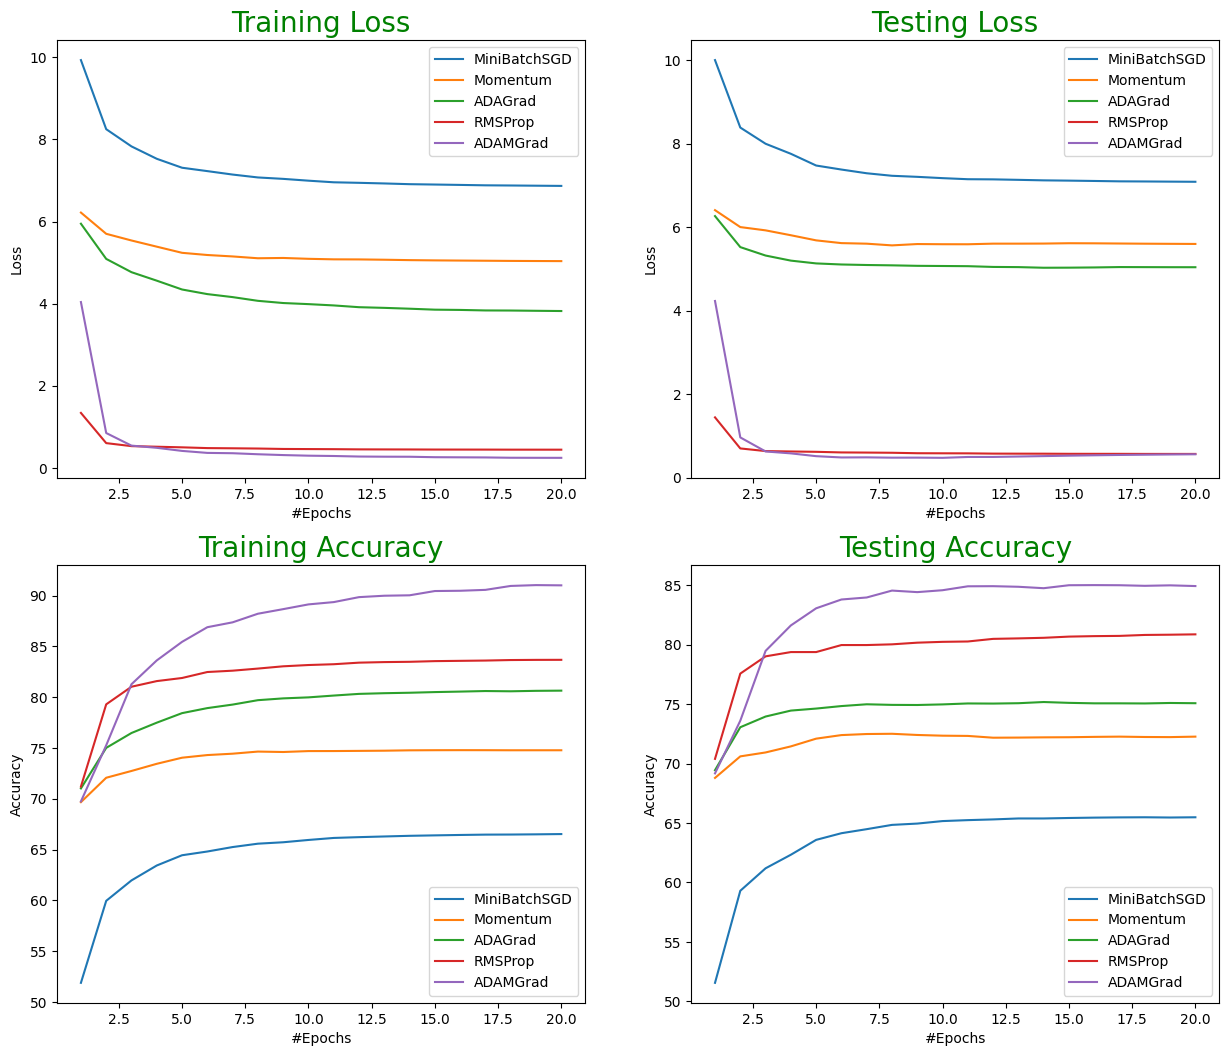

In [96]:
#Results Plotting
import matplotlib.pyplot as plt
figure, axis = plt.subplots(2, 2,figsize=(15, 12.5))

train_accs5,train_losses5,test_accs5,test_losses5

epochs = [ i for i in range(1,21)]

axis[0,0].set_title("Training Loss",fontsize=20,color="green")
axis[0,0].set_xlabel("#Epochs")
axis[0,0].set_ylabel("Loss")
axis[0,0].plot(epochs,train_losses1,label="MiniBatchSGD")
axis[0,0].plot(epochs,train_losses2,label="Momentum")
axis[0,0].plot(epochs,train_losses3,label="ADAGrad")
axis[0,0].plot(epochs,train_losses4,label="RMSProp")
axis[0,0].plot(epochs,train_losses5,label="ADAMGrad")
axis[0,0].legend()


axis[0,1].set_title("Testing Loss",fontsize=20,color="green")
axis[0,1].set_xlabel("#Epochs")
axis[0,1].set_ylabel("Loss")
axis[0,1].plot(epochs,test_losses1,label="MiniBatchSGD")
axis[0,1].plot(epochs,test_losses2,label="Momentum")
axis[0,1].plot(epochs,test_losses3,label="ADAGrad")
axis[0,1].plot(epochs,test_losses4,label="RMSProp")
axis[0,1].plot(epochs,test_losses5,label="ADAMGrad")
axis[0,1].legend()

axis[1,0].set_title("Training Accuracy",fontsize=20,color="green")
axis[1,0].set_xlabel("#Epochs")
axis[1,0].set_ylabel("Accuracy")
axis[1,0].plot(epochs,train_accs1,label="MiniBatchSGD")
axis[1,0].plot(epochs,train_accs2,label="Momentum")
axis[1,0].plot(epochs,train_accs3,label="ADAGrad")
axis[1,0].plot(epochs,train_accs4,label="RMSProp")
axis[1,0].plot(epochs,train_accs5,label="ADAMGrad")
axis[1,0].legend()

axis[1,1].set_title("Testing Accuracy",fontsize=20,color="green")
axis[1,1].set_xlabel("#Epochs")
axis[1,1].set_ylabel("Accuracy")
axis[1,1].plot(epochs,test_accs1,label="MiniBatchSGD")
axis[1,1].plot(epochs,test_accs2,label="Momentum")
axis[1,1].plot(epochs,test_accs3,label="ADAGrad")
axis[1,1].plot(epochs,test_accs4,label="RMSProp")
axis[1,1].plot(epochs,test_accs5,label="ADAMGrad")
axis[1,1].legend()